In [47]:
import json

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

actual_df = pd.read_json('D:/Forecast/wind-forecast/data/WINDACT.json')
forecast_df = pd.read_json('D:/Forecast/wind-forecast/data/WINDFORCAST.json')

In [49]:
actual_df.head()

,startTime,generation
0,2024-05-25T11:00:00Z,3721
1,2024-05-25T10:30:00Z,3527
2,2024-05-25T10:00:00Z,3472
3,2024-05-25T09:30:00Z,3422
4,2024-05-25T09:00:00Z,3041


In [50]:
forecast_df.head()

,publishTime,startTime,generation
0,2024-01-31T22:30:00Z,2024-01-31T23:00:00Z,16909
1,2024-01-31T22:30:00Z,2024-02-01T00:00:00Z,16341
2,2024-01-31T22:30:00Z,2024-02-01T01:00:00Z,15630
3,2024-01-31T22:30:00Z,2024-02-01T02:00:00Z,15049
4,2024-01-31T22:30:00Z,2024-02-01T03:00:00Z,14787


In [51]:
actual_df['startTime'] = pd.to_datetime(actual_df['startTime'])
forecast_df['publishTime'] = pd.to_datetime(forecast_df['publishTime'])
forecast_df['startTime'] = pd.to_datetime(forecast_df['startTime'])

In [52]:
# Resample actual_df to 60 minutes as the forecast data has a time difference of 1 hr 
actual_df_resampled = actual_df.set_index('startTime').resample('60min').first().iloc[1:].reset_index()

# Merge the DataFrames
merged_df = pd.merge_asof(forecast_df, actual_df_resampled, on='startTime', direction='backward', suffixes=('_forecast', '_actual'))

# Calculate the error
merged_df['error'] = merged_df['generation_forecast'] - merged_df['generation_actual']
merged_df['horizon'] = (merged_df['startTime'] - merged_df['publishTime']).dt.total_seconds() / 3600.0

# Temporal Error Analysis
temporal_error = merged_df.groupby('horizon')['error'].mean().reset_index()

# Filter out rows where horizon is a natural number (between 0-48 hours as mentioned in the assignment) starting with 0.5 with 1 hours gap between. 
temporal_error_filtered = temporal_error[~temporal_error['horizon'].isin(range(int(temporal_error['horizon'].min()), int(temporal_error['horizon'].max()) + 1))]

# Display the filtered temporal error
temporal_error_filtered.head(50)


,horizon,error
0,0.5,1313.516129
1,1.5,1457.774194
2,2.5,1234.693548
3,3.5,1434.096774
4,4.5,1464.258065
5,5.5,1392.569892
6,6.5,1441.849462
8,7.5,1441.967742
10,8.5,1420.000000
12,9.5,1291.349593


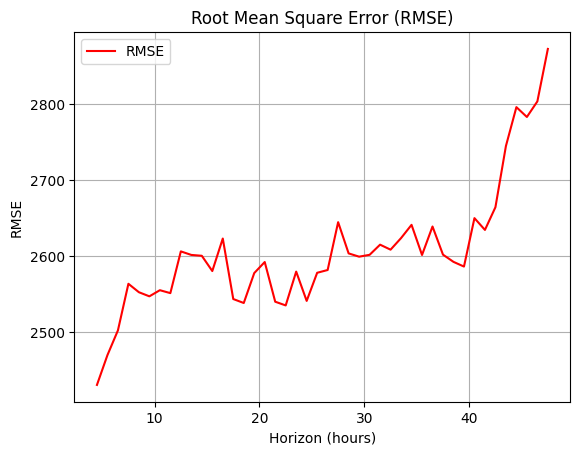

In [74]:
#Calculating Root Mean Square Error and Mean Absolute Error 
merged_df['absolute_error'] = merged_df['error'].abs()
merged_df['squared_error'] = merged_df['error'] ** 2

# Get filtered horizons
filtered_horizons = temporal_error_filtered['horizon']

# Filter merged_df by filtered_horizons
filtered_df = merged_df[merged_df['horizon'].isin(filtered_horizons)]

# Group by horizon to compute error metrics
grouped = filtered_df.groupby('horizon').agg({
    'absolute_error': 'mean',
    'squared_error': 'mean'
}).reset_index()

grouped['rmse'] = np.sqrt(grouped['squared_error'])
grouped['mae'] = grouped['absolute_error']

plt.plot(grouped_filtered['horizon'], grouped_filtered['rmse'].rolling(window=5).mean(), label='RMSE', color='red')  # Smoothing with a rolling window of 5
plt.title('Root Mean Square Error (RMSE)')
plt.xlabel('Horizon (hours)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

RMSE (Root Mean Square Error) provides a measure of the magnitude of errors, with larger errors having a disproportionately greater effect.

- The graph shows that as the forecast horizon increases, RMSE also tends to increase. This means that, as expected, the accuracy of the forecasts generally decreases with longer horizons.
- There is some variability in the RMSE values for different horizons, with occasional dips and peaks, but the overall trensis  increase in error with longer horizons.
- The most noticeable increase in RMSE is after the 40-hour mark, suggesting that the model's performance significantly deteriorates for very long-term forecaste.uture.

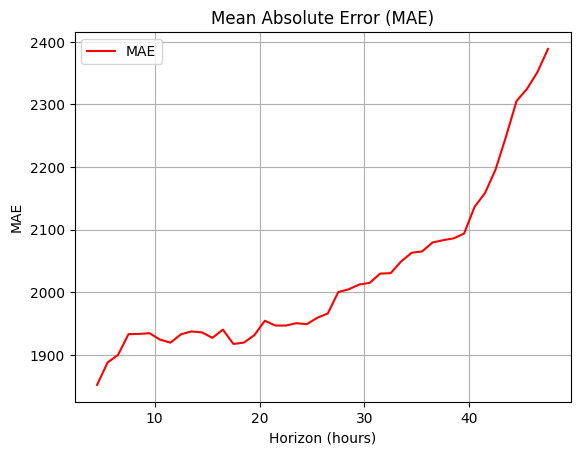

In [72]:
#plot of MAE vs Horizon
plt.plot(grouped_filtered['horizon'], grouped_filtered['mae'].rolling(window=5).mean(), label='MAE', color='red')  # Smoothing with a rolling window of 5
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Horizon (hours)')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

MAE (Mean Absolute Error) provides a straightforward measure of the average magnitude of errors, treating all errors equally regardless of their direction.
- The graph shows that as the forecast horizon increases, MAE also increases. This indicates that the accuracy of the forecasts generally decreases as the time between the forecast and the actual event gets longer.
- Unlike the RMSE graph which had some variability, the MAE graph shows a more consistent upward trend, particularly after the 20-hour mark. This suggests a steady decline in forecast accuracy over time.
- The most noticeable increase in MAE occurs after the 40-hour horizon, indicating that the forecasting model struggles significantly with very long-term forecasts, resulting in larger average err.rs.

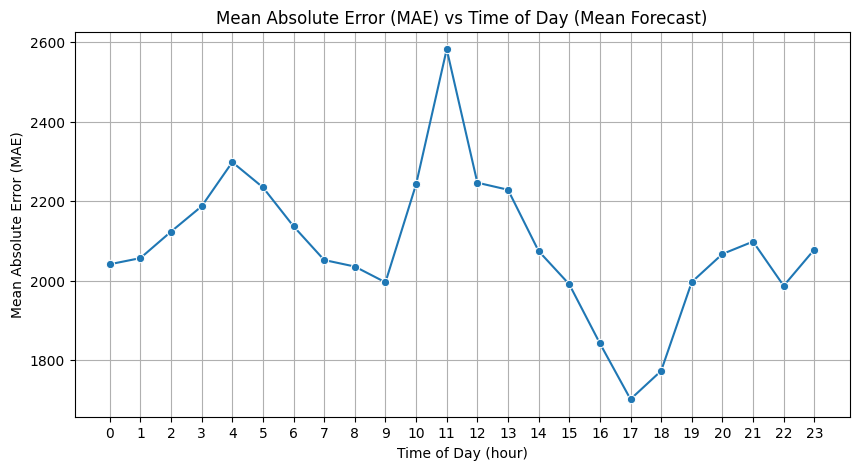

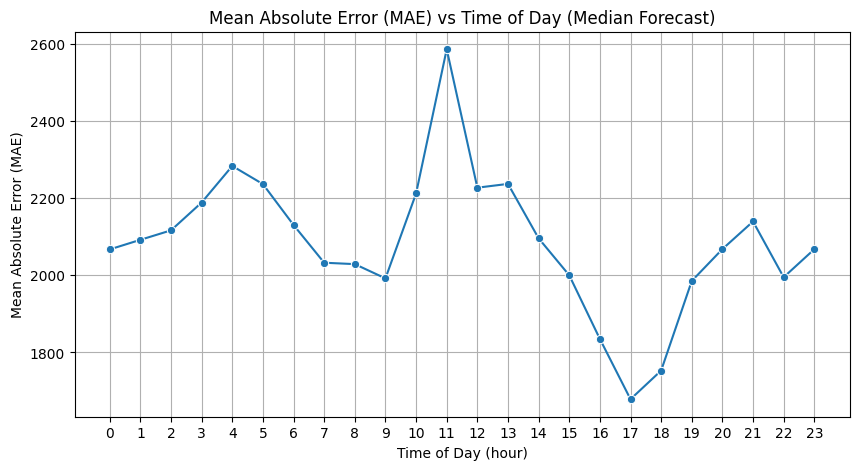

In [65]:
#Calculating MAE vs Time of Day with Mean/Median forecast
# Aggregate forecast data by taking the mean/median of the generation values for each startTime
forecast_df_aggregated = forecast_df.groupby('startTime')['generation'].agg(['mean', 'median']).reset_index()

# Merge the actual and forecast data on startTime
merged_df_mean = pd.merge_asof(forecast_df_aggregated[['startTime', 'mean']], actual_df_resampled, on='startTime', direction='backward')
merged_df_median = pd.merge_asof(forecast_df_aggregated[['startTime', 'median']], actual_df_resampled, on='startTime', direction='backward')

# Calculate the error for mean
merged_df_mean['error'] = merged_df_mean['mean'] - merged_df_mean['generation']
merged_df_mean['absolute_error'] = merged_df_mean['error'].abs()
merged_df_mean['time_of_day'] = merged_df_mean['startTime'].dt.hour

# Calculate the error for median
merged_df_median['error'] = merged_df_median['median'] - merged_df_median['generation']
merged_df_median['absolute_error'] = merged_df_median['error'].abs()
merged_df_median['time_of_day'] = merged_df_median['startTime'].dt.hour

# Group by time of day and calculate mean absolute error
mae_by_time_mean = merged_df_mean.groupby('time_of_day')['absolute_error'].mean().reset_index()
mae_by_time_median = merged_df_median.groupby('time_of_day')['absolute_error'].mean().reset_index()

# Plot MAE vs Time of Day for mean
plt.figure(figsize=(10, 5))
sns.lineplot(data=mae_by_time_mean, x='time_of_day', y='absolute_error', marker='o')
plt.title('Mean Absolute Error (MAE) vs Time of Day (Mean Forecast)')
plt.xlabel('Time of Day (hour)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(range(24))  # Set x-axis ticks to represent each hour of the day
plt.grid(True)
plt.show()

# Plot MAE vs Time of Day for median
plt.figure(figsize=(10, 5))
sns.lineplot(data=mae_by_time_median, x='time_of_day', y='absolute_error', marker='o')
plt.title('Mean Absolute Error (MAE) vs Time of Day (Median Forecast)')
plt.xlabel('Time of Day (hour)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(range(24))  # Set x-axis ticks to represent each hour of the day
plt.grid(True)
plt.show()


- The graph shows that the Mean Absolute Error (MAE) varies significantly throughout the day, indicating that forecast accuracy changes depending on the time of day.

- The highest errors occur around 11 AM, suggesting that forecasts made for this time are less accurate.

- The lowest errors occur around 5 PM, indicating that forecasts for this time are more accurate.
- Graph of Median & Mean are quite similar suggesting that there are no major outlier in the forcast value.

Text(0, 0.5, 'Frequency')

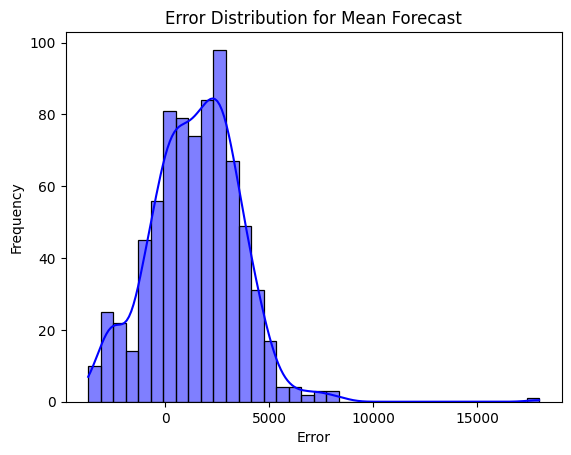

In [75]:
#Plot of error distribution of mean forecast in the form of histogram
sns.histplot(merged_df_mean['error'], kde=True, color='blue')
plt.title('Error Distribution for Mean Forecast')
plt.xlabel('Error')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

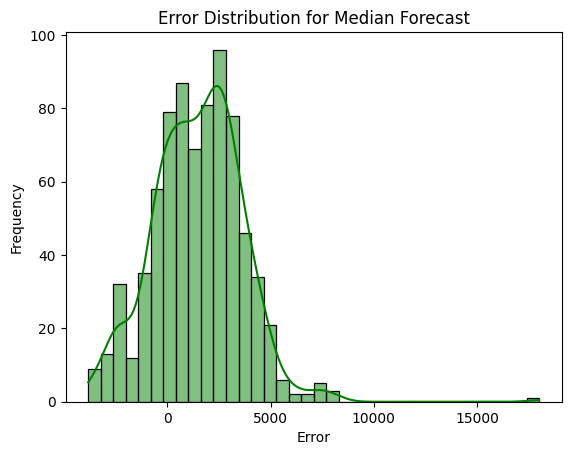

In [76]:
# Plot of error distribution for median forecast in the form of histogram
sns.histplot(merged_df_median['error'], kde=True, color='green')
plt.title('Error Distribution for Median Forecast')
plt.xlabel('Error')
plt.ylabel('Frequency')

- The graph shows highest frequency of forecast errors is around 2000 to 3000 error units, indicating that this range is where most forecast errors fall.
- The distribution is right-skewed, with a long tail extending towards higher error values.This error occurs due to the overestimation of forecast over actual values.
- Most errors are relatively small, with the majority of errors being less than 5000 units, as evidenced by the steep decline in frequency beyond this point.


# Conclusion

1. Model Performance:
The analysis shows that the forecasting model performs reasonably well for short to medium-term forecasts but struggles with long-term accuracy, particularly beyond 40 hours.

2. Temporal Variation:
The accuracy of forecasts varies throughout the day, highlighting the need for time-of-day-specific adjustments or models. This temporal variation can be critical for operational planning and resource allocation.

